## Import libraries

In [195]:
import os
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from shutil import copyfile
from PIL import Image

## Read Input

In [196]:
base_dir = "input/rice_plant_lacks_nutrients"

potassium_dir = os.path.join(base_dir, 'Potassium')
nitrogen_dir = os.path.join(base_dir, 'Nitrogen')
phosphorus_dir = os.path.join(base_dir, 'Phosphorus')

potassium_files = os.listdir(potassium_dir)
nitrogen_files =  os.listdir(nitrogen_dir)
phosphorus_files = os.listdir(phosphorus_dir)

print("Potassium images:", len(potassium_files))
print("Nitrogen images:", len(nitrogen_files))
print("Phosporus images:", len(phosphorus_files))

Potassium images: 383
Nitrogen images: 440
Phosporus images: 333


## Create dataset

In [197]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [198]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1156 files belonging to 3 classes.
Using 925 files for training.


In [199]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1156 files belonging to 3 classes.
Using 231 files for validation.


In [200]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [201]:
class_names = train_ds.class_names
print(class_names)

['Nitrogen', 'Phosphorus', 'Potassium']


## Visualize the input

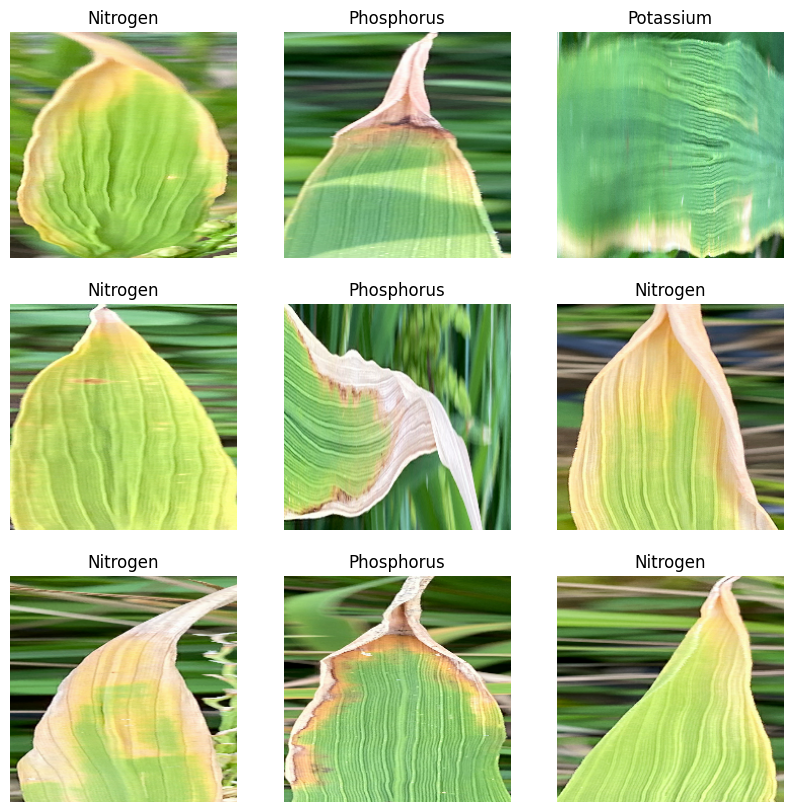

In [202]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Augmentation and Preprocessing

In [203]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

## Train model

In [204]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=IMG_SHAPE),
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 sequential_25 (Sequential)  (None, 224, 224, 32)      0         
                                                                 
 sequential_26 (Sequential)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                

In [221]:
model.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [222]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
29/29 [==============================] - 47s 2s/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.3809 - val_sparse_categorical_accuracy: 0.8392
Epoch 2/20
29/29 [==============================] - 57s 2s/step - loss: 0.3595 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.4134 - val_sparse_categorical_accuracy: 0.8342
Epoch 3/20
29/29 [==============================] - 63s 2s/step - loss: 0.3539 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4002 - val_sparse_categorical_accuracy: 0.8442
Epoch 4/20
29/29 [==============================] - 50s 2s/step - loss: 0.3309 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.4327 - val_sparse_categorical_accuracy: 0.7889
Epoch 5/20
29/29 [==============================] - 49s 2s/step - loss: 0.2777 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.5955 - val_sparse_categorical_accuracy: 0.7437
Epoch 6/20
29/29 [==============================] - 48s 2s/step - loss: 0.2951 - sparse_categorical_accuracy: 